In [12]:
# ライブラリをインポート

# データ操作と数値計算のため
import pandas as pd
import numpy as np

# データ可視化のため
import matplotlib.pyplot as plt
import seaborn as sns

# 統計モデリングと計量経済分析のため
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# for ignore warning
import warnings
warnings.filterwarnings('ignore')

In [142]:
url = "https://www.fbc.keio.ac.jp/~tyabu/keiryo/growth_data.csv"
_df = pd.read_csv(url)

date_range = pd.date_range(
  start = '1981-03-01',
  end = '2007-12-31',
  freq = 'Q' # 四半期
)
_df['date'] = date_range # date列に上書き

_df['d_1991'] = (_df['date'] > '1991-03-31').astype(int) # 1991年第1四半期以前は0，さもなくば1．
_df['d_1991_growth'] = _df['d_1991'] * _df['growth'].shift() # d_1991列が1をとる時，前期のgrowthをとる．
_df['growth_lag'] = _df['growth'].shift() # 前期のgrowth
df = _df.dropna()
df.head()

,date,growth,d_1991,d_1991_growth,growth_lag
1,1981-06-30,6.149155,0,0.0,4.320439
2,1981-09-30,4.221881,0,0.0,6.149155
3,1981-12-31,2.468659,0,0.0,4.221881
4,1982-03-31,3.497315,0,0.0,2.468659
5,1982-06-30,3.035303,0,0.0,3.497315


# 作図

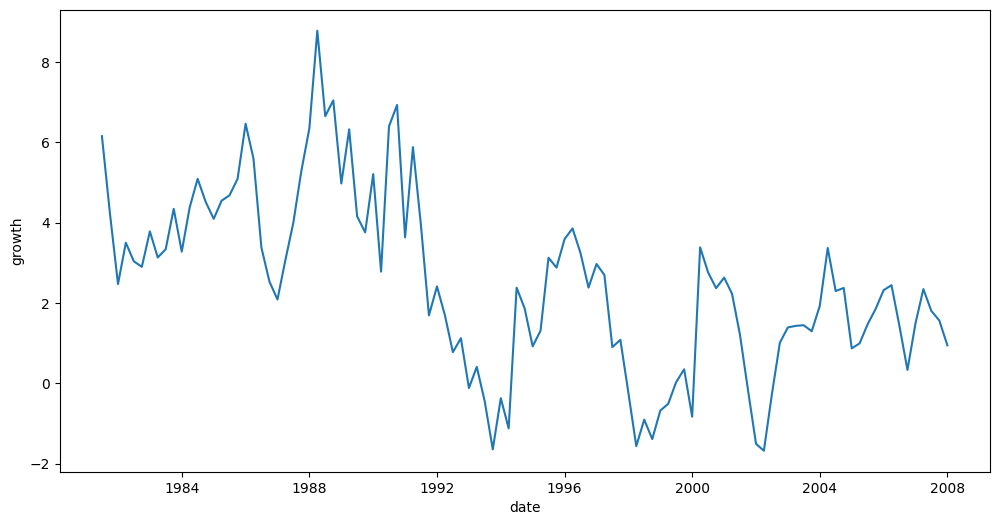

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(
    df['date'],
    df['growth']
)
plt.xlabel('date')
plt.ylabel('growth')
plt.show()

# 7.4.1節の推定結果

In [150]:
endog = df['growth']
exog = df['growth_lag']
exog = sm.add_constant(exog)

model_1 = sm.OLS(endog, exog)
results_1 = model_1.fit()
print(results_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 growth   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     234.5
Date:                Sun, 11 Aug 2024   Prob (F-statistic):           1.62e-28
Time:                        18:50:44   Log-Likelihood:                -172.92
No. Observations:                 107   AIC:                             349.8
Df Residuals:                     105   BIC:                             355.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3965      0.181      2.187      0.0

In [16]:
endog = df['growth']
exog = df[['growth_lag', 'd_1991', 'd_1991_growth']]
exog = sm.add_constant(exog)

model_2 = sm.OLS(endog, exog)
results_2 = model_2.fit()
print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:                 growth   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     96.64
Date:                Sun, 11 Aug 2024   Prob (F-statistic):           7.98e-30
Time:                        16:55:20   Log-Likelihood:                -164.08
No. Observations:                 107   AIC:                             336.2
Df Residuals:                     103   BIC:                             346.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.2968      0.583      3.943

# 7.4.2節の推定結果

In [131]:
endog = df['growth']
exog = df['growth_lag']
exog = sm.add_constant(exog)

model_1 = sm.OLS(endog, exog)
results_1 = model_1.fit()
print(results_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 growth   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     234.5
Date:                Sun, 11 Aug 2024   Prob (F-statistic):           1.62e-28
Time:                        17:25:53   Log-Likelihood:                -172.92
No. Observations:                 107   AIC:                             349.8
Df Residuals:                     105   BIC:                             355.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3965      0.181      2.187      0.0

In [146]:
def sup_f_test(df=df):

    # F統計量を格納するデータフレームを作成
    columns = ['date', 'f_stat']
    df_f_stat = pd.DataFrame(columns=columns)

    # 構造変化点の候補を計算する．
    T = len(df) # サンプルサイズ

    T_min = round(0.15 * T) # 構造変化点の候補の始期．整数を用いる
    T_min_date = _df.sort_values('date').iloc[T_min - 1]['date'] # date列でソートし，T_min番目の値を取得
    print(f'構造変化点の候補の始期:{T_min_date}')

    T_max = round((1 - 0.15) * T) # 構造変化点の候補の終期．整数を用いる
    T_max_date = _df.sort_values('date').iloc[T_max - 1]['date'] # date列でソートし，T_max番目の値を取得
    print(f'構造変化点の候補の終期:{T_max_date}')

    T_B_list = list(range(T_min, T_max + 1)) # 構造変化点の候補のリストを作成．

    # 帰無仮説が正しいという前提で推定
    endog = df['growth']         # 被説明変数
    exog = df['growth_lag']      # 説明変数
    exog = sm.add_constant(exog) # 定数項を追加
    H_0 = sm.OLS(endog, exog).fit()
    ssr_0 = np.sum(H_0.resid**2) # 残差２乗和を取得

    # 構造変化点の候補を一つずつ試す．
    for T_B in T_B_list:
        T_B_date = _df.sort_values('date').iloc[T_B - 1]['date'] # date列でソートし，T_B番目の値を取得
        _df['d'] = (_df['date'] > T_B_date).astype(int) # 構造変化点の候補T_Bの期以前は0，それ以降は1
        _df['d_growth'] = _df['d'] * _df['growth'].shift() # dが1のときだけ前期のgrowthを入れる．
        df = _df.dropna()

        # 対立仮説が正しいという前提で推定
        endog = df['growth']                       # 被説明変数
        exog = df[['growth_lag', 'd', 'd_growth']] # 説明変数
        exog = sm.add_constant(exog)
        H_1 = sm.OLS(endog, exog).fit()
        ssr_1 = np.sum(H_1.resid**2) # 残差２乗和を取得

        # F統計量を計算する
        K = 1 # 制約なしモデルの説明変数の数
        f_stat = (ssr_0 - ssr_1) / (K + 1) / ssr_1 * (T - 2 * (K + 1)) # F統計量を計算する．

        new_f_stat = pd.Series(
            [T_B_date, f_stat],
            index = df_f_stat.columns
        )
        df_f_stat = pd.concat(
            [
                df_f_stat,
                new_f_stat.to_frame().T
            ],
            ignore_index = True
        )

    sup_f_stat = df_f_stat['f_stat'].max() # F値の最大値
    structural_break_point = df_f_stat.loc[df_f_stat['f_stat'].idxmax(), 'date'] # 構造変化点を取得
    print(f'構造変化点:{structural_break_point}')
    print(f'supF統計量:{sup_f_stat:.02f}')

    plt.figure(figsize=(12, 6))
    plt.plot(
        df_f_stat['date'],
        df_f_stat['f_stat'],
    )
    plt.xlabel('date')
    plt.ylabel('F-stat')

    current_ymin, current_ymax = plt.ylim()
    plt.ylim(current_ymin, current_ymax * 1.2)

    # 最大値の位置にテキストで値を表示
    plt.annotate(
        f'sup F = {sup_f_stat:.2f}',
        xy = (structural_break_point, sup_f_stat),
        xytext = (10, 10),
        textcoords = 'offset points',
        arrowprops = dict(arrowstyle='->', connectionstyle='arc3,rad=0')
    )
    plt.show()

    return

構造変化点の候補の始期:1984-12-31 00:00:00
構造変化点の候補の終期:2003-09-30 00:00:00
構造変化点:1991-03-31 00:00:00
supF統計量:9.25


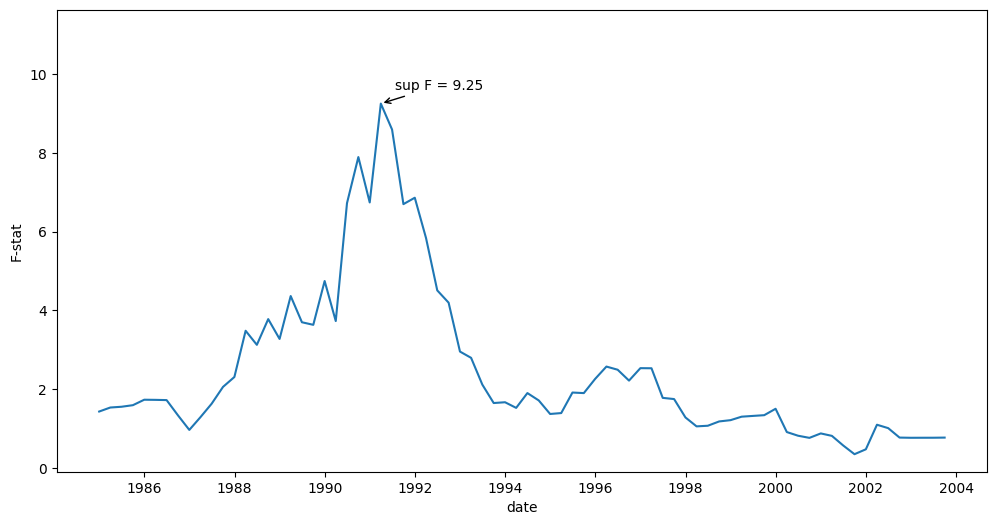

In [147]:
sup_f_test()